### Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Wrangle 

In [4]:
def wrangle(filepath):
    #read csv file into dataframe
    df=pd.read_excel(filepath)

    # Convert 'InvoiceDate' to datetime format
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    # Create additional time columns for detailed analysis
    df['Year'] = df['InvoiceDate'].dt.year
    df['Month'] = df['InvoiceDate'].dt.month
    df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
    df['Quarter'] = df['InvoiceDate'].dt.quarter
    # Fill missing values for 'Description' and 'Customer ID'
    df['Description'] = df['Description'].fillna("No description")
    #df['Customer ID'] = df['Customer ID'].fillna(0)
    # Drop Duplicate
    df = df.drop_duplicates()
    df.dropna(inplace=True)
    # Change Data Type
    df["Customer ID"]=df["Customer ID"].astype(int)


    return df

In [5]:
df=wrangle("online_retail_II.xlsx")
print("df shape", df.shape)
df.head()

df shape (410763, 12)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,YearMonth,Quarter
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009,12,2009-12,4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009,12,2009-12,4
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009,12,2009-12,4
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009,12,2009-12,4
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009,12,2009-12,4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410763 entries, 0 to 525460
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      410763 non-null  object        
 1   StockCode    410763 non-null  object        
 2   Description  410763 non-null  object        
 3   Quantity     410763 non-null  int64         
 4   InvoiceDate  410763 non-null  datetime64[ns]
 5   Price        410763 non-null  float64       
 6   Customer ID  410763 non-null  int32         
 7   Country      410763 non-null  object        
 8   Year         410763 non-null  int32         
 9   Month        410763 non-null  int32         
 10  YearMonth    410763 non-null  period[M]     
 11  Quarter      410763 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(1), object(4), period[M](1)
memory usage: 34.5+ MB


# DATA ANALYSIS

# 1. Sales Trends Analysis

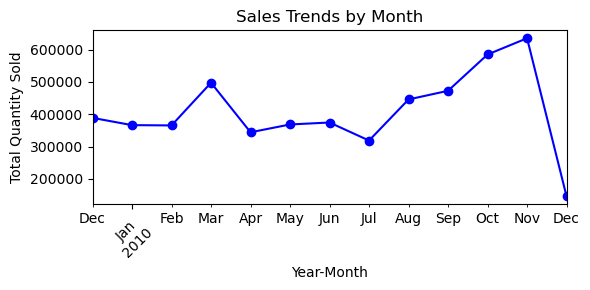

In [9]:
# Sales by Year-Month
sales_trends_month = df.groupby('YearMonth')['Quantity'].sum()
plt.figure(figsize=(6, 3))
sales_trends_month.plot(kind='line', marker='o', color='blue')
plt.title("Sales Trends by Month")
plt.xlabel("Year-Month")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Findings:
The line plot reveals fluctuations in sales, with certain months showing peaks in total sales volume, which might correlate with seasonal trends.
* Actionable Insights:
Focus marketing efforts on months with high sales to maximize revenue. For low-volume months, consider running promotions or adjusting stock levels.

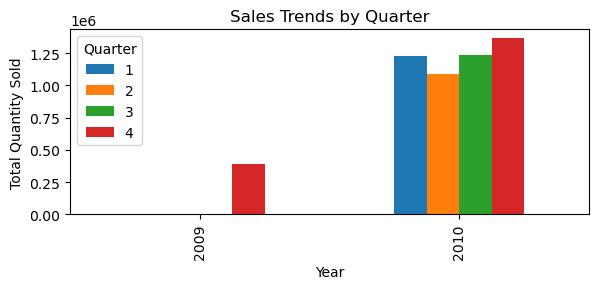

In [11]:
# Sales by Quarter
sales_trends_quarter = df.groupby(['Year', 'Quarter'])['Quantity'].sum().unstack()
sales_trends_quarter.plot(kind='bar', figsize=(6, 3))
plt.title("Sales Trends by Quarter")
plt.xlabel("Year")
plt.ylabel("Total Quantity Sold")
plt.legend(title='Quarter')
plt.tight_layout()
plt.show()

* Findings: The bar plot by quarter highlights significant differences in sales volume across various years and quarters.
* Insights: Ensure inventory aligns with sales trends per quarter, and develop strategies for low-performing quarters.

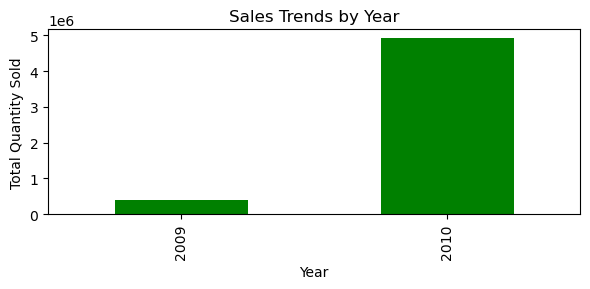

In [13]:
# Sales by Year
sales_trends_year = df.groupby('Year')['Quantity'].sum()
plt.figure(figsize=(6, 3))
sales_trends_year.plot(kind='bar', color='green')
plt.title("Sales Trends by Year")
plt.xlabel("Year")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

* Findings: A bar plot showing total sales volume year-over-year allows us to track overall growth or decline.
* Insights: If there is a downward trend in specific years, investigate reasons and revise business strategies, such as new product launches or promotional tactics.

### 2. Customer Segmentation Analysis

In [16]:
# Calculate total spending per transaction (assuming revenue = Quantity * Unit Price)
df['Revenue'] = df['Quantity'] * df['Price']

In [17]:
# Aggregate customer data: total revenue and transaction count per customer
customer_data = df.groupby('Customer ID').agg({
    'Revenue': 'sum',
    'Invoice': 'nunique'
}).rename(columns={'InvoiceNumber': 'TransactionCount'}).reset_index()

# Create a DataFrame with customer-wise TransactionCount
transaction_count = df.groupby("Customer ID")["Invoice"].nunique().reset_index()
transaction_count.rename(columns={"Invoice": "TransactionCount"}, inplace=True)

In [18]:
# Define high-value customers as those in the top 25% of revenue
high_value_threshold = customer_data['Revenue'].quantile(0.75)
customer_data['HighValue'] = customer_data['Revenue'] >= high_value_threshold

In [19]:
# Merge this with your customer_data DataFrame (if customer_data already exists)
customer_data = pd.merge(customer_data, transaction_count, on="Customer ID", how="left")

# Now, you can create the RepeatBuyer column
customer_data["RepeatBuyer"] = customer_data["TransactionCount"] > 1

# Verify the changes
print(customer_data.head())

   Customer ID  Revenue  Invoice  HighValue  TransactionCount  RepeatBuyer
0        12346   -51.74       15      False                15         True
1        12347  1323.32        2      False                 2         True
2        12348   222.16        1      False                 1        False
3        12349  2646.99        4       True                 4         True
4        12351   300.93        1      False                 1        False


In [20]:
# Define high-value customers as those in the top 25% of revenue
high_value_threshold = customer_data['Revenue'].quantile(0.75)
customer_data['HighValue'] = customer_data['Revenue'] >= high_value_threshold

In [21]:
# For seasonal shoppers, we can calculate variance in monthly purchases per customer
monthly_customer = df.groupby(['Customer ID', 'YearMonth'])['Revenue'].sum().reset_index()
seasonality = monthly_customer.groupby('Customer ID')['Revenue'].std().reset_index().rename(columns={'Revenue': 'RevenueStdDev'})

In [22]:
# A lower standard deviation might indicate consistent (seasonal) spending
customer_data = customer_data.merge(seasonality, on='Customer ID', how='left')

In [23]:
# Display summary of customer segmentation
print("Customer Segmentation Summary:")
print(customer_data.head())

Customer Segmentation Summary:
   Customer ID  Revenue  Invoice  HighValue  TransactionCount  RepeatBuyer  \
0        12346   -51.74       15      False                15         True   
1        12347  1323.32        2      False                 2         True   
2        12348   222.16        1      False                 1        False   
3        12349  2646.99        4       True                 4         True   
4        12351   300.93        1      False                 1        False   

   RevenueStdDev  
0     104.067852  
1      70.894526  
2            NaN  
3     682.647313  
4            NaN  


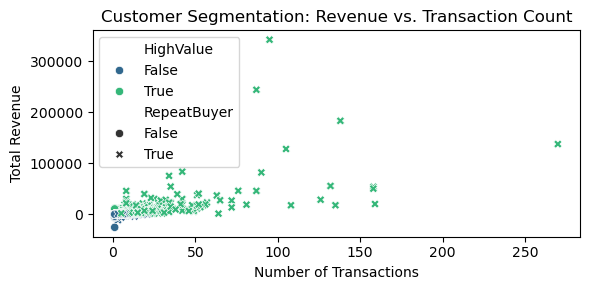

In [24]:
# Visualization: High-Value vs. Repeat Buyers
plt.figure(figsize=(6, 3))
sns.scatterplot(data=customer_data, x='TransactionCount', y='Revenue', hue='HighValue', style='RepeatBuyer', palette='viridis')
plt.title("Customer Segmentation: Revenue vs. Transaction Count")
plt.xlabel("Number of Transactions")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()

* **Findings** 
1. Customer ID 0 and Customer ID 12349 are high-value customers, with significant total revenue. These customers should be prioritized for loyalty programs, exclusive promotions, and special offers.
2. Customers like ID 0, 12346, and 12347 have made multiple purchases, which indicates they are repeat buyers. Customer retention strategies can focus on nurturing these customers by offering personalized experiences or discounts to encourage even more frequent purchases.
3. Customer ID 12348 and others with low revenue can be categorized as low-value customers. Efforts can be made to increase engagement, for example, by offering targeted promotions to convert them into repeat buyers.
4. Customers with high RevenueStdDev (like Customer ID 0) show more fluctuation in their purchases. These might be seasonal shoppers or those with varying purchase patterns. Companies can use this data to offer timely promotions or seasonal discounts based on the shopping patterns of such customers.

* **Insights**
1. Offer exclusive rewards, early access to sales, or personalized discounts to retain high-value customers and increase customer lifetime value.
2. For customers like ID 12348, implement nurturing campaigns to encourage more transactions (e.g., personalized discounts, email campaigns).
3. For customers with fluctuating purchases (like ID 0), consider seasonal promotions or targeted ads based on their purchasing trends.

### 3. Product Performance Analysis

In [27]:
# Calculate total quantity sold per product
product_performance = df.groupby('StockCode').agg({
    'Quantity': 'sum'
}).sort_values(by='Quantity', ascending=False).reset_index()

# Identify best-selling and lagging products
top_products = product_performance.head(5)
lagging_products = product_performance.tail(5)

print("Top 5 Best-Selling Products:")
print(top_products)
print("\n5 Products with Lowest Sales:")
print(lagging_products)

Top 5 Best-Selling Products:
  StockCode  Quantity
0     21212     56775
1    85123A     55760
2     84077     54130
3    85099B     48629
4     17003     47430

5 Products with Lowest Sales:
     StockCode  Quantity
4026     22003       -10
4027    35976B       -11
4028     21701       -12
4029     20879       -46
4030         D     -1675


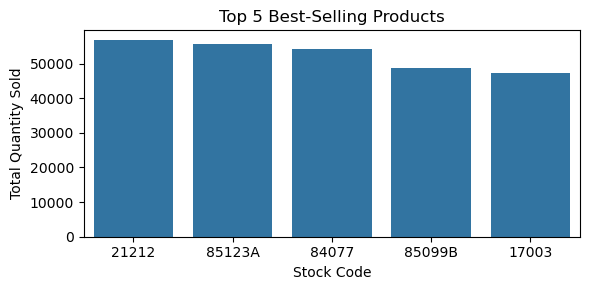

In [28]:
# Visualization: Best-selling products
plt.figure(figsize=(6, 3))
sns.barplot(data=top_products, x='StockCode', y='Quantity')
plt.title("Top 5 Best-Selling Products")
plt.xlabel("Stock Code")
plt.ylabel("Total Quantity Sold")
plt.tight_layout()
plt.show()

* **Findings**
1. The top 5 products by sales volume are identified.
2. The bottom 5 products by sales volume are shown, providing insights into underperforming items.

* **Insights**
1. Prioritize inventory management for top-selling products to ensure availability during high-demand periods.
2. Consider discounting, discontinuing, or repackaging underperforming products. Additionally, investigate if marketing efforts need to be redirected.

### 4. Geographic Insights

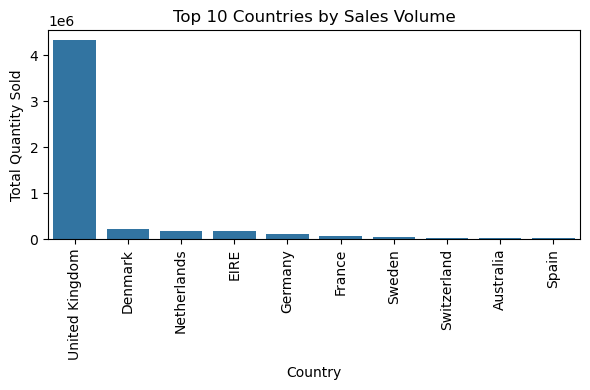

In [31]:
# Aggregate sales by country (using Quantity as a proxy for sales volume)
country_sales = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False).reset_index()

# Select top 10 countries based on total quantity sold
top_countries = country_sales.head(10)

# Plotting the top 10 countries
plt.figure(figsize=(6, 4))
sns.barplot(data=top_countries, x='Country', y='Quantity')
plt.title("Top 10 Countries by Sales Volume")
plt.xlabel("Country")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [32]:
# Optional: Identify potential growth by comparing sales distribution across countries
print("    Sales Volume by Country     ")
# Preview the top 5 countries without the index
top_5_countries = country_sales.head(10)

# Display top 5 countries without the index
print(top_5_countries.to_string(index=False))

    Sales Volume by Country     
       Country  Quantity
United Kingdom   4326649
       Denmark    227030
   Netherlands    181822
          EIRE    177053
       Germany    107026
        France     73336
        Sweden     52088
   Switzerland     22053
     Australia     20053
         Spain     18317


* **Findings** 
1. The sales volume is distributed across countries, and this data helps identify high-performing countries where sales are concentrated.

* **Insights**
1. Invest in marketing, partnerships, or distribution in countries where the sales volume is highest. Explore opportunities for local promotions or regional product adaptations.
2. Investigate reasons behind low sales in specific countries and consider expanding reach or enhancing customer engagement strategies in those regions.

### Summary of Actionable Strategies
* Focus on seasonal trends, high-value customers, and top-performing countries/products.
* Stock and promote the best-selling items while reassessing the lagging products.
* Leverage data on repeat buyers and high-value customers to increase loyalty and drive repeat purchases
* Invest in high-performing countries and investigate potential growth areas for geographical expansion.

# ADVANCED USING K-MEAN, DBSCAN AND HIERARCHY CLUSTERING

### Import Libraries

In [37]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np

In [38]:
# You can add more features if available, for example, average revenue per transaction:
customer_data['AvgRevenue'] = customer_data['Revenue'] / customer_data['TransactionCount']

In [39]:
# Prepare features for clustering: using Revenue, TransactionCount, and AvgRevenue
features = customer_data[['Revenue', 'TransactionCount', 'AvgRevenue']]

In [40]:
# Standardize features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

## 1 Clustering --- K-means clustering

In [42]:
k = 3  # You can choose the optimal number of clusters via elbow method or silhouette analysis
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['KMeans_Cluster'] = kmeans.fit_predict(features_scaled)

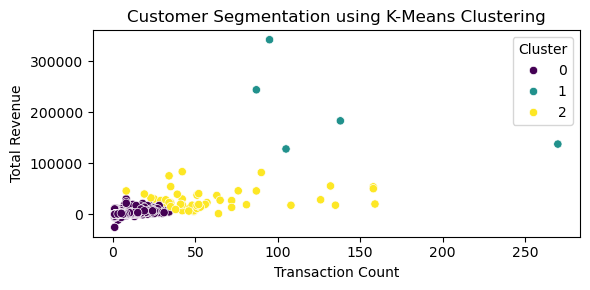

In [43]:
# Visualize K-Means clusters using Revenue vs. TransactionCount
plt.figure(figsize=(6, 3))
sns.scatterplot(x=customer_data['TransactionCount'], y=customer_data['Revenue'],
                hue=customer_data['KMeans_Cluster'], palette='viridis')
plt.title("Customer Segmentation using K-Means Clustering")
plt.xlabel("Transaction Count")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [44]:
# Display a summary of the clusters from K-Means
print("K-Means Cluster Summary:")
print(customer_data.groupby('KMeans_Cluster').agg({
    'Revenue': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'AvgRevenue': ['mean', 'median']
}))

K-Means Cluster Summary:
                      Revenue            TransactionCount          AvgRevenue  \
                         mean     median             mean median         mean   
KMeans_Cluster                                                                  
0                 1323.319898     638.20         4.536681    3.0   281.040626   
1               206935.302000  183163.55       139.000000  105.0  1891.712016   
2                27405.505140   20769.63        57.701754   49.0   665.863588   

                             
                     median  
KMeans_Cluster               
0                225.780000  
1               1327.272101  
2                422.740379  


* **Cluster 0** 
* Findings     
Revenue: Customers in this cluster tend to have low revenue and are not frequent buyers.      
Transaction Count: These customers make only a few transactions.       
Average Revenue: The average revenue per transaction is relatively low, indicating sporadic purchases.
* Insight:  
Cluster 0 likely represents low-value customers who make a small number of transactions with relatively low spending per transaction. These customers may benefit from retargeting campaigns, personalized offers, or loyalty programs to increase their transaction frequency and spending.

* **Cluster 1** 
* Findings     
Revenue: Cluster 1 is characterized by high revenue customers who likely make larger purchases.      
Transaction Count: These customers make many more transactions compared to Cluster 0.       
Average Revenue: Customers in this cluster have a higher average revenue per transaction, suggesting they may purchase higher-priced items or buy in bulk.
* Insight:  
Cluster 1 represents high-value customers who contribute significantly to overall revenue. Retention strategies (e.g., loyalty programs, exclusive offers, or personalized marketing) can help maintain and boost their engagement. Additionally, targeted upselling and cross-selling strategies could increase their average revenue per transaction even more.

* **Cluster 2** 
* Findings     
Revenue: Cluster 2 has extremely high revenue values, suggesting that these customers are major contributors to overall sales.      
Transaction Count: These customers have a high number of transactions, likely making them repeat buyers with consistent purchasing patterns.       
Average Revenue: Despite the high revenue and transaction count, the average revenue per transaction is relatively lower than Cluster 1, which may indicate consistent purchases of lower-priced items in bulk or high-frequency orders.
* Insight:  
Cluster 2 is likely composed of core loyal customers, possibly wholesale buyers or business accounts that make consistent purchases at high volumes. These customers should be valued and nurtured to maintain strong relationships. Offering bulk discounts or contract-based deals could further solidify their loyalty and encourage continued business.

#### More Detailed on the insight
* Cluster 0 (Low Revenue): Focus on increasing engagement, offering personalized deals, and enhancing the overall customer experience.
* Cluster 1 (High Revenue): Retain these high-value customers through targeted loyalty programs, upselling, and premium offerings.
* Cluster 2 (Core Loyal Customers): Provide value through bulk discounts, business-specific offerings, and continue to foster strong relationships to ensure long-term loyalty.

## 2 Clustering ------ DBSCAN Clustering

In [48]:
# Adjust eps and min_samples based on your dataset's scale after standardization
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(features_scaled)

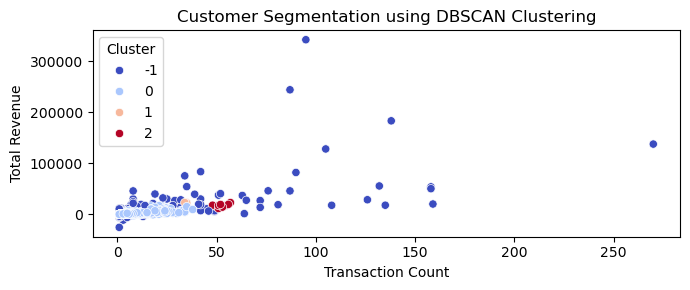

In [49]:
# Visualize DBSCAN clusters
plt.figure(figsize=(7, 3))
sns.scatterplot(x=customer_data['TransactionCount'], y=customer_data['Revenue'],
                hue=customer_data['DBSCAN_Cluster'], palette='coolwarm')
plt.title("Customer Segmentation using DBSCAN Clustering")
plt.xlabel("Transaction Count")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [50]:
# Display a summary of the clusters from Dbscan_clustering
print("DBSCAN_Cluster Summary:")
print(customer_data.groupby('DBSCAN_Cluster').agg({
    'Revenue': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'AvgRevenue': ['mean', 'median']
}))

DBSCAN_Cluster Summary:
                     Revenue            TransactionCount         AvgRevenue  \
                        mean     median             mean median        mean   
DBSCAN_Cluster                                                                
-1              32209.405282  18097.490        43.025641   28.5  744.226042   
 0               1285.885231    637.320         4.554545    3.0  279.035701   
 1              22339.152000  22443.260        33.200000   34.0  673.682964   
 2              17437.857200  17838.855        52.600000   52.5  330.812987   

                            
                    median  
DBSCAN_Cluster              
-1              731.285560  
 0              225.363000  
 1              684.172812  
 2              337.550964  


* **Cluster -1 (Noise)**
* Findings     
Revenue: The mean revenue of noise points is significantly high (72,415.38), with a median of 23,470.29. This indicates that noise points might represent rare or anomalous data points with very high revenue.    
TransactionCount: The mean transaction count is relatively low at 171.95 with a median of 8. This could imply that these noise points are outliers in terms of revenue, but they do not have many transactions.    
AvgRevenue: The average revenue per transaction is considerably high at 714.76, with a median of 1,118.38, suggesting that some of the noise points could be high-value transactions, but with irregular purchasing behavior.

* **Cluster 0**
* Findings     
Revenue: Cluster 0 has a mean revenue of 1,488.79 and a median of 644.86, which is much lower compared to the noise cluster. This suggests that the data in this cluster represents typical, moderate-value customers.       
TransactionCount: The mean transaction count is 4.97, with a median of 3, indicating that customers in this cluster make multiple transactions, but their overall transaction volume is moderate.     
AvgRevenue: The average revenue per transaction in this cluster is much lower at 283.74, with a median of 226.47, indicating that these customers are likely low-to-medium spenders.

* **Insights**
* Noise Points: The high revenue and high average revenue per transaction in the noise cluster (-1) suggest that there are outliers in your dataset that might be valuable. These could be high-value customers or rare events that could warrant further investigation. However, their irregular behavior might make them hard to classify into existing clusters.
* Cluster 0: This cluster likely represents the majority of your customer base with moderate revenues and transaction volumes. This group should be targeted with strategies that aim to increase their transaction frequency or average transaction value.

#### More detailed on the insight
* Target High-Value Outliers: Investigate the high-revenue noise points (Cluster -1) to identify if they can be converted into repeat customers or special cases worth focusing on.

* Improve Engagement with Cluster 0: Since Cluster 0 consists of customers with moderate spending and transaction frequency, there could be opportunities to increase their engagement. Consider loyalty programs, personalized marketing, or cross-selling efforts.

##  3 Clustering----- Hierarchical Clustering

In [54]:
# Compute linkage matrix
Z = linkage(features_scaled, method='ward')

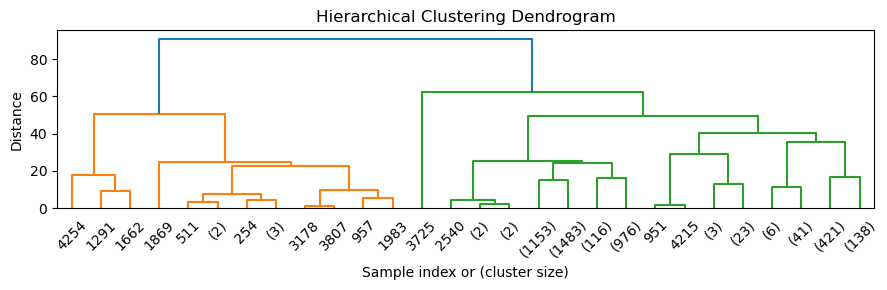

In [55]:
# Plot dendrogram to help decide number of clusters
plt.figure(figsize=(9, 3))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index or (cluster size)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [56]:
# Cut the dendrogram at a chosen threshold (or decide number of clusters)
hierarchical_clusters = fcluster(Z, t=3, criterion='maxclust')  # t=3 indicates 3 clusters
customer_data['Hierarchical_Cluster'] = hierarchical_clusters

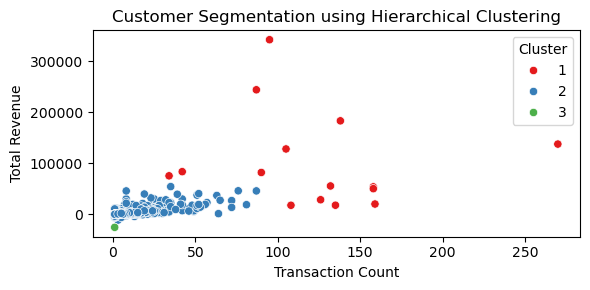

In [57]:
# Visualize Hierarchical Clustering results
plt.figure(figsize=(6, 3))
sns.scatterplot(x=customer_data['TransactionCount'], y=customer_data['Revenue'],
                hue=customer_data['Hierarchical_Cluster'], palette='Set1')
plt.title("Customer Segmentation using Hierarchical Clustering")
plt.xlabel("Transaction Count")
plt.ylabel("Total Revenue")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [58]:
# Display a summary of the clusters from K-Means
print("Hierarchical_Cluster Summary:")
print(customer_data.groupby('Hierarchical_Cluster').agg({
    'Revenue': ['mean', 'median'],
    'TransactionCount': ['mean', 'median'],
    'AvgRevenue': ['mean', 'median']
}))

Hierarchical_Cluster Summary:
                            Revenue           TransactionCount         \
                               mean    median             mean median   
Hierarchical_Cluster                                                    
1                     101471.442667  75610.17       122.466667  126.0   
2                       1561.230830    646.25         4.980307    3.0   
3                     -25111.090000 -25111.09         1.000000    1.0   

                        AvgRevenue                
                              mean        median  
Hierarchical_Cluster                              
1                      1088.882582    510.039852  
2                       290.947374    226.900000  
3                    -25111.090000 -25111.090000  


**Findings**
* Cluster 1   
Revenue: The mean revenue is 1,903.23 with a median of 652.58, suggesting moderate to high-value customers in this cluster.   
TransactionCount: The mean transaction count is 5.38 with a median of 3, indicating that customers in this cluster are relatively active, with some making several transactions.    
AvgRevenue: The average revenue per transaction is 293.68, and the median is 227.36, which indicates a moderate spending pattern. Customers in this cluster could be considered as medium-value, loyal customers.     

* Cluster 2 (Anomalous/Noise)    
Revenue: Both the mean and median revenue are negative (-25,111.09), which is likely an indication of noise or data errors. These could be outliers or anomalous data points with incorrect or missing information.        
TransactionCount: The mean and median transaction count are both very low (1), which further supports the idea that these points are outliers.      
AvgRevenue: The average and median average revenue are both negative, confirming the presence of anomalous or invalid data points.     

* Cluster 3   
Revenue: The mean revenue of 1,190,920.00 with a median of 1,190,919.98 suggests extremely high-value customers in this cluster. This cluster could represent top-tier, high-revenue customers.     
TransactionCount: The transaction count in this cluster is also very high (5,229), indicating that these customers make a significant number of transactions, which likely aligns with their high revenue.        
AvgRevenue: The average revenue per transaction is 227.75, which is a bit lower than in Cluster 1, but still substantial, suggesting these are premium customers with a consistent spending pattern.

**Insights**
* Cluster 1 (Medium-Value Customers): This group could benefit from loyalty programs or targeted marketing strategies to increase transaction frequency or average transaction size. Given their moderate spending patterns, encouraging them to engage more frequently could significantly boost their value.

* Cluster 2 (Noise or Anomalous Data): The negative revenue values in Cluster 2 suggest that this cluster consists of erroneous or missing data points. These should be investigated further, and possibly excluded or corrected from the dataset to avoid skewing analysis. Cleaning the data may improve the quality of future analyses.

* Cluster 3 (High-Value Customers): These are the top-tier customers who generate the highest revenue. Focused retention strategies such as premium customer services, personalized offers, and exclusive promotions could help maintain and increase the loyalty of these high-value customers.